<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/29_Keras_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Keras - Autoencoders**

---

In this lesson, we learn how to build autoencoders in Keras.

Tutorial Credit - https://blog.keras.io/building-autoencoders-in-keras.html

An autoencoder is an unsupervised machine learning algorithm. In our example here it takes an image as input and then tries to reconstruct that image using less information.

They do this by projecting higher dimensional data to a lower dimension (similar to Principal Component Analysis) by keeping the feautres of most importance. This is called the latent space.

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1522830223/AutoEncoder_kfqad1.png)


### **An Autoencoder is comprised of these two Networks**

**Encoder**: compresses/downsamples the input image into a lesser number of bits. This lesser number of bits is called the latent-space or bottleneck.

**Decoder**: tries to reconstruct the input using only the encoding of the input. If the decoder can reconstruct the image accurately from the output of the encoder you have a properly functioning encoder (able to produce good encodings) and decoder system.

## **1. Building a Simple Autoencoder**

We'll build a single fully-connected neural layer as encoder and as decoder.



In [ ]:
# Import and creating some helper functions
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## **1. Load and preprocess our MNIST Dataset**

#### **We then create a noisy version of our training and test data**

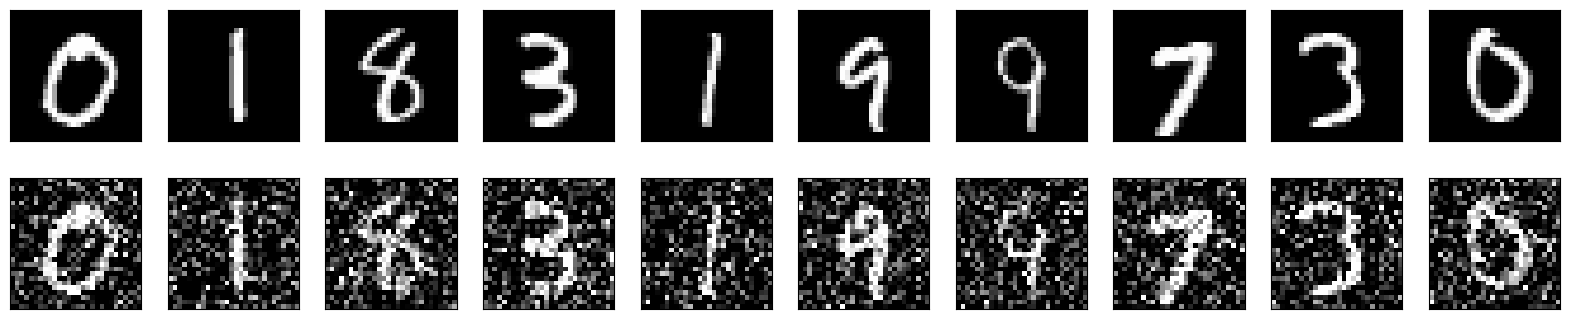

In [ ]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## **2. Now let's also create our autoencoder model**


We are going to use the Functional API to build our convolutional autoencoder (this should be familar to PyTorch users).

In [ ]:
# Our input shape is 28 x 28 x 1
input = layers.Input(shape=(28, 28, 1))

# The Encoder Model
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# The Decoder Model
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder - Note it is the entire concatenation of the encoder and decoder
autoencoder = Model(input, x)

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

## **3. Train our autoencoder**

We will train our autoencoder using `train_data` as both our input data and target.

NOTE: We are setting up the validation data using the same format.

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 295ms/step - loss: 0.2373 - val_loss: 0.0733
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 292ms/step - loss: 0.0728 - val_loss: 0.0696
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 277ms/step - loss: 0.0697 - val_loss: 0.0681
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 280ms/step - loss: 0.0683 - val_loss: 0.0672
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 133s 283ms/step - loss: 0.0677 - val_loss: 0.0666
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 136s 291ms/step - loss: 0.0669 - val_loss: 0.0661
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 130s 278ms/step - loss: 0.0665 - val_loss: 0.0657
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 279ms/step - loss: 0.0661 - val_loss: 0.0654
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 133s 283ms/step - loss: 0.0657 - val_loss: 0.0651
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - loss: 0.0654 - val_loss: 0.0648
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 128s 272ms/step - loss: 0.0652 - val_loss: 0.0646
Epoch 12

### **4. Get our Autoencoder Predictions**

Now we'll predict on our test dataset and display the original image together with the prediction from our autoencoder.

Notice how close the predictions are to the original image. However if you look closely you can see slight differences.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


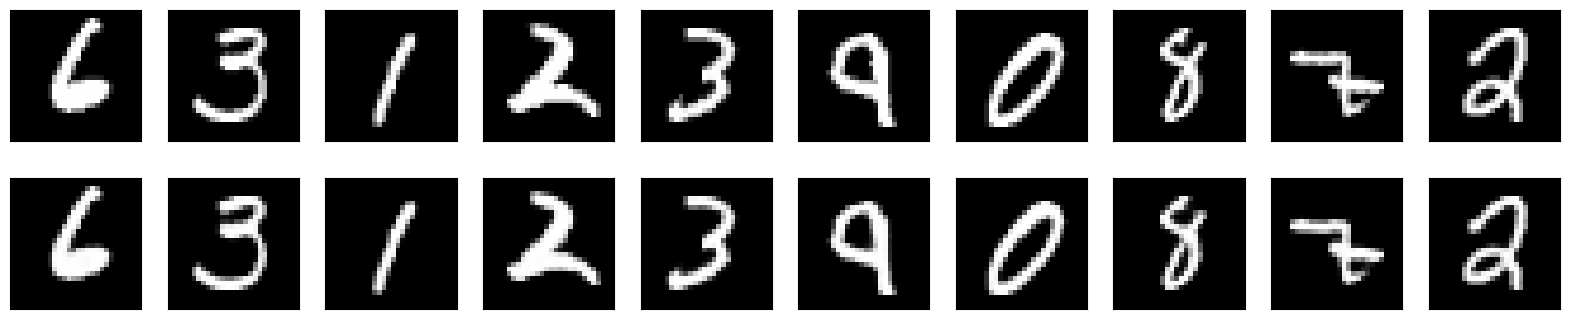

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

## **5. Now let's use our Autoencoder as a Denoiser**

To do this we'll retrain it using the noisy data as our input and the clean data as our target. This teaches our autoencoder to learn how to denoise the images.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 133s 284ms/step - loss: 0.1103 - val_loss: 0.0932
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 285ms/step - loss: 0.0934 - val_loss: 0.0910
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 279ms/step - loss: 0.0914 - val_loss: 0.0899
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 130s 278ms/step - loss: 0.0902 - val_loss: 0.0892
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 146s 287ms/step - loss: 0.0895 - val_loss: 0.0887
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 275ms/step - loss: 0.0891 - val_loss: 0.0881
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 287ms/step - loss: 0.0886 - val_loss: 0.0878
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 288ms/step - loss: 0.0882 - val_loss: 0.0873
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 274ms/step - loss: 0.0877 - val_loss: 0.0871
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 270ms/step - loss: 0.0876 - val_loss: 0.0868
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 130s 278ms/step - loss: 0.0873 - val_loss: 0.0866
Epoch 12

## **6. Now let's evaluate it's performance on our noisy Test Data**

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


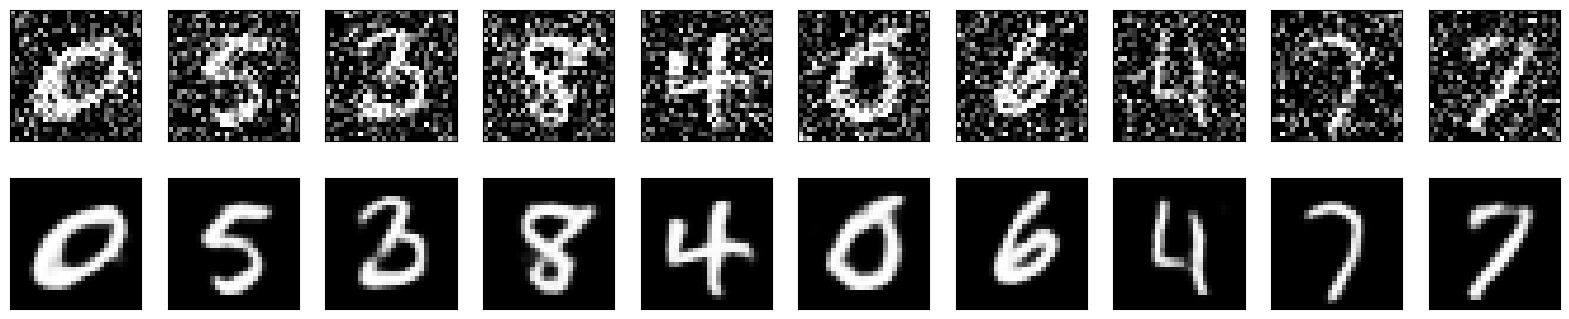

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)